# Продвинутые архитектуры свёрточных нейросетей

Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import imageio

from skimage.transform import resize
from tensorflow.keras import layers

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

##### Загрузка датасета

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

##### Визуализация датасета

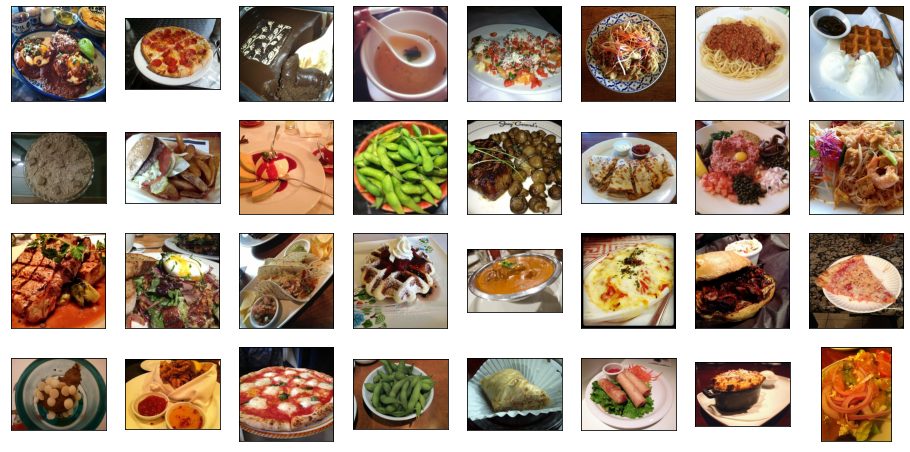

In [4]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

##### Создание пайплайна данных

In [5]:
INP_SIZE = 224
NUM_EPOCHS = 5
BATCH_SIZE = 64

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127.5 - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

##### Подготовка модели CNN

In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Fine-tuning весов предобученной модели
#base_model.trainable = False # Заморозка весов предобученной модели

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation((-0.2, 0.2)),
])
    
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(INP_SIZE, INP_SIZE, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])

##### Подготовка к обучению

In [7]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE) 

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', 
    write_graph=False, update_freq=100, profile_batch=0)

##### Model Summary

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


##### Обучение модели

In [11]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/5
1065/1065 [==============================] - 271s 245ms/step - loss: 3.0938 - accuracy: 0.3032 - val_loss: 1.9429 - val_accuracy: 0.5103
Epoch 2/5
1065/1065 [==============================] - 260s 243ms/step - loss: 1.5009 - accuracy: 0.6140 - val_loss: 1.5820 - val_accuracy: 0.5931
Epoch 3/5
1065/1065 [==============================] - 260s 243ms/step - loss: 1.2311 - accuracy: 0.6770 - val_loss: 1.3830 - val_accuracy: 0.6406
Epoch 4/5
1065/1065 [==============================] - 261s 245ms/step - loss: 1.0636 - accuracy: 0.7160 - val_loss: 1.3966 - val_accuracy: 0.6388
Epoch 5/5
1065/1065 [==============================] - 259s 242ms/step - loss: 0.9540 - accuracy: 0.7410 - val_loss: 1.2853 - val_accuracy: 0.6691
Wall time: 21min 49s


##### Оценка качества модели

In [12]:
%%time

model.evaluate(test_ds)

59/59 [==============================] - 17s 277ms/step - loss: 1.2886 - accuracy: 0.6687
Wall time: 16.8 s


[1.2886275053024292, 0.6686970591545105]

##### Запуск предсказания на изображении из интернета

In [31]:
def prepare_image(img):
    img = img.astype(np.float32)/127.5 - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

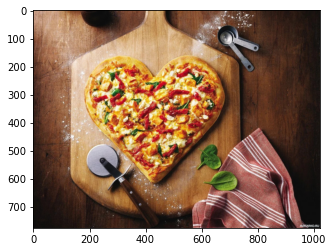

In [32]:
img = imageio.imread('pizza.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [33]:
pred = model(img[None, ...], training=False)
ds_info.features['label'].int2str(np.argmax(pred.numpy()[0]))

'pizza'

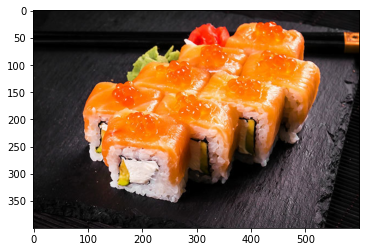

In [36]:
img = imageio.imread('test.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [37]:
pred = model(img[None, ...], training=False)
ds_info.features['label'].int2str(np.argmax(pred.numpy()[0]))

'sushi'